In [1]:
#allows drawing digrams in jupyeter notebooks
%matplotlib inline
#loading tensorboard
%load_ext tensorboard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#specific tensorflow libraries
import tensorflow as tf
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import datetime

In [4]:
from pandas.plotting import scatter_matrix

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [6]:
def Train_Test_XY_normalize_PCA(TrainX, TrainY, TestX, PCA_n = None):
    
    # normalize data
    scaler_new = StandardScaler()
    scaler_new.fit(TrainX)
    X_train_scale = scaler_new.transform(TrainX)
    X_test_scale_list = [scaler_new.transform(TestX_now) for TestX_now in TestX]

    print(f'X shape {X_train_scale.shape}')
    
    if PCA_n != None:
        # dimension reduction
        TrainX_PCA = Train_Test_XY_PCA(X_train_scale, PCA_n = PCA_n)
        print(f'X shape {TrainX_PCA.shape}')
    
        # normalize again
        scaler_new = StandardScaler()
        scaler_new.fit(TrainX_PCA)
        X_train_scale = scaler_new.transform(TrainX_PCA)
        
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_scale,TrainY,
                                                       test_size=.2,
                                                       shuffle=True,
                                                       random_state=2020,
                                                       stratify=TrainY)
    
    
    return X_train, X_val, y_train, y_val, X_test_scale_list

In [7]:
import tensorflow.keras.backend as Kb

# Write a custom loss function
def custom_loss(y_true, y_pred):
    binary_crossentropy = Kb.mean(Kb.binary_crossentropy(y_true, y_pred), axis = -1)
    prob_constraint = Kb.square(Kb.sum(y_pred, axis = -1)
                                - Kb.sum(y_true, axis = -1))

    return(binary_crossentropy+prob_constraint)

# simple NN model

In [8]:
# see_column = np.array(['PTS', 'W','L', 'GF', 'GA', 'SRS', 
#                                   'SOS', 'PK%', 'S%', 'SV%', 'SAT%', 
#                                   'MsS', 'TA/GA'])
see_column = np.array(['W', 'L', 'GA', 'SAT%', 'TA/GA'])

see_column2 = np.array(['Winner',
                       'F_home_assists', 'F_home_goals', 'F_home_pim', 'F_home_shots',
                       'F_home_blocked', 'F_home_pm', 'D_home_assists', 'D_home_goals',
                       'D_home_pim', 'D_home_shots', 'D_home_blocked', 'D_home_hits',
                       'D_home_pm', 'G_home_GAA', 'F_away_assists', 'F_away_goals',
                       'F_away_pim', 'F_away_shots', 'F_away_blocked', 'F_away_hits',
                       'F_away_pm', 'D_away_assists', 'D_away_goals', 'D_away_pim',
                       'D_away_shots', 'D_away_blocked', 'D_away_hits', 'D_away_pm',
                       'G_away_GAA', 'F_home_hits'])


column_home = np.array([i+'_H' for i in see_column])
column_away = np.array([i+'_A' for i in see_column])

column_name = np.concatenate((column_home,column_away))

column_name = np.concatenate((see_column2,column_name))
#  column_name = np.concatenate((column_name,['class'])) # Winner is the class

# ## only consider tm data
# column_home = np.array([i+'_H' for i in see_column])
# column_away = np.array([i+'_A' for i in see_column])
# column_name = np.concatenate((column_home,column_away))
# column_name = np.concatenate((['Winner'],column_name)) # Winner is the class

# ## only consider players data
# column_name = see_column2

print(column_name)
print(len(column_name))

['Winner' 'F_home_assists' 'F_home_goals' 'F_home_pim' 'F_home_shots'
 'F_home_blocked' 'F_home_pm' 'D_home_assists' 'D_home_goals' 'D_home_pim'
 'D_home_shots' 'D_home_blocked' 'D_home_hits' 'D_home_pm' 'G_home_GAA'
 'F_away_assists' 'F_away_goals' 'F_away_pim' 'F_away_shots'
 'F_away_blocked' 'F_away_hits' 'F_away_pm' 'D_away_assists'
 'D_away_goals' 'D_away_pim' 'D_away_shots' 'D_away_blocked' 'D_away_hits'
 'D_away_pm' 'G_away_GAA' 'F_home_hits' 'W_H' 'L_H' 'GA_H' 'SAT%_H'
 'TA/GA_H' 'W_A' 'L_A' 'GA_A' 'SAT%_A' 'TA/GA_A']
41


#### Train NN model

In [9]:
tm_players = pd.read_csv('tm_player_stats_2005_2021.csv')

tm_players[column_name].sample(1)

,Winner,F_home_assists,F_home_goals,F_home_pim,F_home_shots,F_home_blocked,F_home_pm,D_home_assists,D_home_goals,D_home_pim,...,W_H,L_H,GA_H,SAT%_H,TA/GA_H,W_A,L_A,GA_A,SAT%_A,TA/GA_A
9336,0,1.006847,0.68976,1.74293,7.149183,1.994861,0.261621,0.899206,0.308675,1.517525,...,0.573171,0.304878,2.463415,52.8,0.874309,0.280488,0.621951,3.280488,37.5,0.787197


In [10]:
playoff = pd.read_csv('playoff_stats_2005_2021.csv')
playoff_test = playoff[:-87]
playoff_pred = playoff[1436:1509]

In [11]:
Traindf = tm_players[column_name]
TrainX_array = Traindf[column_name[1:]].to_numpy()
TrainY_array = Traindf[column_name[0]].to_numpy()
print(sum(TrainY_array)/len(TrainY_array))

Testdf = playoff_test[column_name]
TestX_array = Testdf[column_name[1:]].to_numpy()
TestY_array = Testdf[column_name[0]].to_numpy()
y_test = TestY_array

Preddf = playoff_pred[column_name]
PredX_array = Preddf[column_name[1:]].to_numpy()
y_pred = Preddf[column_name[0]].to_numpy()


0.45341645885286785


In [12]:
# X_train, X_test, y_train, y_test = Train_Test_XY_normalize_PCA(TrainX_array, 
#                                                                TrainY_array)

X_train, X_val, y_train, y_val, [X_pred, X_test] = Train_Test_XY_normalize_PCA(TrainX_array, 
                                                                    TrainY_array, 
                                                                   # TestX_array)                                                                     
                                                                    [PredX_array, TestX_array])

X shape (20050, 40)


In [13]:
def NN_TF_model(structure, ipt_dim, learning_rate=0.01, drop_rate = None):
    model=Sequential()
    print(f'structure = {structure}, learning_rate = {learning_rate}')
    model.add(layers.Dense(structure[0], input_shape=(ipt_dim,), activation='relu'))
    if drop_rate != None:
        print(f'drop_rate = {drop_rate}')
        model.add(layers.Dropout(rate = drop_rate, input_shape=(structure[0],)))
    
    for i in range(len(structure)-1):
        model.add(layers.Dense(structure[i+1], activation='relu'))
        if drop_rate != None:
            model.add(layers.Dropout(rate = drop_rate, input_shape=(structure[i+1],)))
        
    model.add(layers.Dense(1, activation='sigmoid'))

    opt = optimizers.SGD(learning_rate=learning_rate)
#     opt = optimizers.Adam(learning_rate=learning_rate)
    # opt = optimizers.Nadam(learning_rate=learning_rate)

    # model.compile(loss='mean_squared_error', optimizer=opt)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    # model.compile(loss=custom_loss, optimizer=opt)
    # model.compile(loss='huber', optimizer=opt)
    # model.compile(loss='binary_focal_crossentropy', optimizer=opt)
    print(model.summary())
    
    return model

In [14]:
def NN_prototype(X_train, 
                 y_train,
                 val_set,
                 structure, 
                 epoch = 300, 
                 b_size = 100,
                 learning_rate = 0.01,
                 drop_rate = None):
    #creating unique name for tensorboard directory
    log_dir = "logs/NN/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    #Tensforboard callback function
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    print()
    print()
    print()
    print('Now working with:',log_dir)
    print(f'epoch number = {epoch}, batch_size = {b_size}')
    struct = structure
    dim = X_train.shape[1]
    model = NN_TF_model(structure = structure, ipt_dim = dim, learning_rate = learning_rate, drop_rate = drop_rate)
    history = model.fit(X_train,
                      y_train,
                      epochs=epoch,
                      batch_size=b_size,
                      shuffle=True,
                      validation_data=val_set,
                      callbacks=[tensorboard_callback],
                      verbose=0)
    ## split the validation set with test_train_split method
    # validation_split = 0.2,
    return model, history

In [15]:
def plot_accuracy(model, history):
#     model.test_on_batch(X_test, y_test)
#     model.metrics_names
    print(history.history.keys())
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b.', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    # plt.figure()

    # plt.plot(epochs, loss, 'b.', label='Training loss')
    # plt.plot(epochs, val_loss, 'g', label='Validation loss')
    # plt.title('Training and validation loss')
    # plt.legend()

    plt.show()

In [16]:
def train_test_confusionM(X_train, y_train, X_test, y_test,verbose = True):
    m = metrics.Accuracy()
    mc = metrics.CategoricalAccuracy()
    
    y_hat=model.predict(X_train)>0.5
    y_hat=np.squeeze(y_hat)*1
    m.update_state(y_train, y_hat)
    mc.update_state(y_train, y_hat)
    train_acc = m.result().numpy()
    if verbose:
        print('away win rate = ', sum(y_hat)/len(y_hat))
#         print('Train data accuracy',train_acc)
        # print('Train data categorical accuracy',mc.result().numpy())
        print(tf.math.confusion_matrix(y_train, y_hat))

    y_hat=model.predict(X_test)>0.5
    y_hat=np.squeeze(y_hat)*1
    
    m.update_state(y_test, y_hat)
    test_acc = m.result().numpy()
    if verbose:
        print('away win rate = ',sum(y_hat)/len(y_hat))
#         print('Test data accuracy',m.result().numpy())
        print(tf.math.confusion_matrix(y_test, y_hat))
    
    return train_acc,test_acc 

# after several different runs of NN, I might go with this structure
* structure: [10, 5]
* epoch = 600
* learning_rate = 0.01
* drop_rate = 0.2




Now working with: logs/NN/20220603-131935
epoch number = 600, batch_size = 100
structure = [10, 5], learning_rate = 0.01
drop_rate = 0.2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                410       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 471
Trainable params: 471
Non-trai

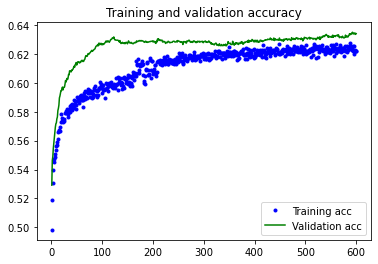

502/502 [==============================] - 0s 625us/step
away win rate =  0.39320448877805486
tf.Tensor(
[[6285 2482]
 [3448 3825]], shape=(2, 2), dtype=int32)
126/126 [==============================] - 0s 615us/step
away win rate =  0.38902743142144636
tf.Tensor(
[[1587  605]
 [ 863  955]], shape=(2, 2), dtype=int32)
Train data accuracy 0.63029927

Validation data accuracy 0.63102245

45/45 [==============================] - 0s 770us/step
away win rate =  0.33612273361227335
tf.Tensor(
[[527 248]
 [425 234]], shape=(2, 2), dtype=int32)
3/3 [==============================] - 0s 1ms/step
away win rate =  0.3424657534246575
tf.Tensor(
[[30 14]
 [18 11]], shape=(2, 2), dtype=int32)
Test data accuracy 0.5306834

Pred data accuracy 0.5321832


In [17]:
structures_list = [[10, 5]]
epoch_list = np.array([600])
learning_rate_list = np.array([0.01])

for s in structures_list:
    for e in epoch_list:
        for l in learning_rate_list:
            model, history = NN_prototype(X_train, 
                                          y_train,
                                          (X_val, y_val),
                                          s, 
                                          epoch = e, 
                                          b_size = 100,
                                          drop_rate = 0.2,
                                          learning_rate = l)
            
            plot_accuracy(model, history)
            train_acc, val_acc = train_test_confusionM(X_train, 
                                                        y_train, 
                                                        X_val, 
                                                        y_val,
                                                        verbose = True)
            
            print('Train data accuracy',train_acc)
            print()
            print('Validation data accuracy',val_acc)
            print()
            test_acc, pred_acc = train_test_confusionM(X_test, 
                                                        y_test,
                                                        X_pred, 
                                                        y_pred,
                                                        verbose = True)
            print('Test data accuracy',test_acc)
            print()
            print('Pred data accuracy',pred_acc)

In [18]:
y_hat=model.predict(X_pred)>0.5
y_hat=np.squeeze(y_hat)*1
print(y_hat)

3/3 [==============================] - 0s 2ms/step
[0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 0]


In [23]:
playoff_pred['Predict_winner'] = y_hat
df = playoff_pred[['homeAbbrev', 'awayAbbrev', 'Winner', 'Predict_winner']]
print(df.to_string())

     homeAbbrev awayAbbrev  Winner  Predict_winner
1436        MIN        STL     1.0               0
1437        EDM        LAK     1.0               0
1438        NYR        PIT     1.0               1
1439        FLA        WSH     1.0               0
1440        COL        NSH     0.0               0
1441        CGY        DAL     0.0               0
1442        CAR        BOS     0.0               1
1443        TOR        TBL     1.0               1
1444        MIN        STL     0.0               0
1445        EDM        LAK     0.0               0
1446        NYR        PIT     0.0               1
1447        FLA        WSH     0.0               0
1448        COL        NSH     0.0               0
1449        CGY        DAL     1.0               0
1450        BOS        CAR     0.0               0
1451        TBL        TOR     1.0               0
1452        STL        MIN     1.0               0
1453        LAK        EDM     1.0               1
1454        WSH        FLA     

/var/folders/4d/xm0qnc311dxdk482_sb4k01h0000gn/T/ipykernel_6482/3387907331.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playoff_pred['Predict_winner'] = y_hat
